In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

In [ ]:
# Load datasets
train_file_path = "dataset/train/DailyDelhiClimateTrain.csv"
test_file_path = "dataset/test/DailyDelhiClimateTest.csv"

df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Convert 'date' column to datetime and set as index
df_train["date"] = pd.to_datetime(df_train["date"])
df_train.set_index("date", inplace=True)

df_test["date"] = pd.to_datetime(df_test["date"])
df_test.set_index("date", inplace=True)

# Normalize numerical values using MinMaxScaler (fit on training data only)
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns, index=df_test.index)

# Save the scaler to inverse transform later
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'meantemp'
    return np.array(X), np.array(y)

# Define sequence length (e.g., using past 30 days to predict next day)
SEQ_LENGTH = 60

# Convert DataFrame to NumPy array
train_values = df_train_scaled.values
test_values = df_test_scaled.values

# Create sequences
X_train, y_train = create_sequences(train_values, SEQ_LENGTH)
X_test, y_test = create_sequences(test_values, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).requires_grad_()
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).requires_grad_()
print(X_train_torch.shape)


torch.Size([1402, 60, 4])


In [ ]:
# Define PyTorch Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for batching
BATCH_SIZE = 16

train_dataset = TimeSeriesDataset(X_train_torch, y_train_torch)
test_dataset = TimeSeriesDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Confirm dataset shapes
print("Training Data Shape:", X_train_torch.shape, y_train_torch.shape)
print("Testing Data Shape:", X_test_torch.shape, y_test_torch.shape)

Training Data Shape: torch.Size([1402, 60, 4]) torch.Size([1402, 1])
Testing Data Shape: torch.Size([54, 60, 4]) torch.Size([54, 1])


In [ ]:
# Define the GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = X_train_torch.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

# Initialize model
model = GRUModel(input_size, hidden_size, num_layers, output_size)
print(model)

GRUModel(
  (gru): GRU(4, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Training setup
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 \
                            #  , weight_decay=1e-4)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    teacher_forcing_ratio = 0.5  # 50% chance of using actual target instead of model output

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs: [16, 60, 4], targets: [16, 1]
        optimizer.zero_grad()
        outputs = model(inputs)

        if np.random.rand() < teacher_forcing_ratio:
          outputs = targets  # Use actual value during training

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.0018
Epoch [2/50], Loss: 0.0015
Epoch [3/50], Loss: 0.0013
Epoch [4/50], Loss: 0.0013
Epoch [5/50], Loss: 0.0014
Epoch [6/50], Loss: 0.0015
Epoch [7/50], Loss: 0.0014
Epoch [8/50], Loss: 0.0014
Epoch [9/50], Loss: 0.0012
Epoch [10/50], Loss: 0.0014
Epoch [11/50], Loss: 0.0018
Epoch [12/50], Loss: 0.0013
Epoch [13/50], Loss: 0.0015
Epoch [14/50], Loss: 0.0012
Epoch [15/50], Loss: 0.0012
Epoch [16/50], Loss: 0.0012
Epoch [17/50], Loss: 0.0015
Epoch [18/50], Loss: 0.0013
Epoch [19/50], Loss: 0.0013
Epoch [20/50], Loss: 0.0014
Epoch [21/50], Loss: 0.0013
Epoch [22/50], Loss: 0.0013
Epoch [23/50], Loss: 0.0012
Epoch [24/50], Loss: 0.0017
Epoch [25/50], Loss: 0.0015
Epoch [26/50], Loss: 0.0016
Epoch [27/50], Loss: 0.0014
Epoch [28/50], Loss: 0.0017
Epoch [29/50], Loss: 0.0012
Epoch [30/50], Loss: 0.0015
Epoch [31/50], Loss: 0.0011
Epoch [32/50], Loss: 0.0016
Epoch [33/50], Loss: 0.0013
Epoch [34/50], Loss: 0.0016
Epoch [35/50], Loss: 0.0012
Epoch [36/50], Loss: 0.0012
E

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    predictions = []
    actuals = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

# Convert predictions and actuals to NumPy arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform predictions and actuals to original scale
scaler = joblib.load("scaler.pkl")  # Load previously saved scaler
predictions_original = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], df_train_scaled.shape[1] - 1))), axis=1))[:, 0]

actuals_original = scaler.inverse_transform(
    np.concatenate((actuals, np.zeros((actuals.shape[0], df_train_scaled.shape[1] - 1))), axis=1))[:, 0]

Test Loss: 0.0026


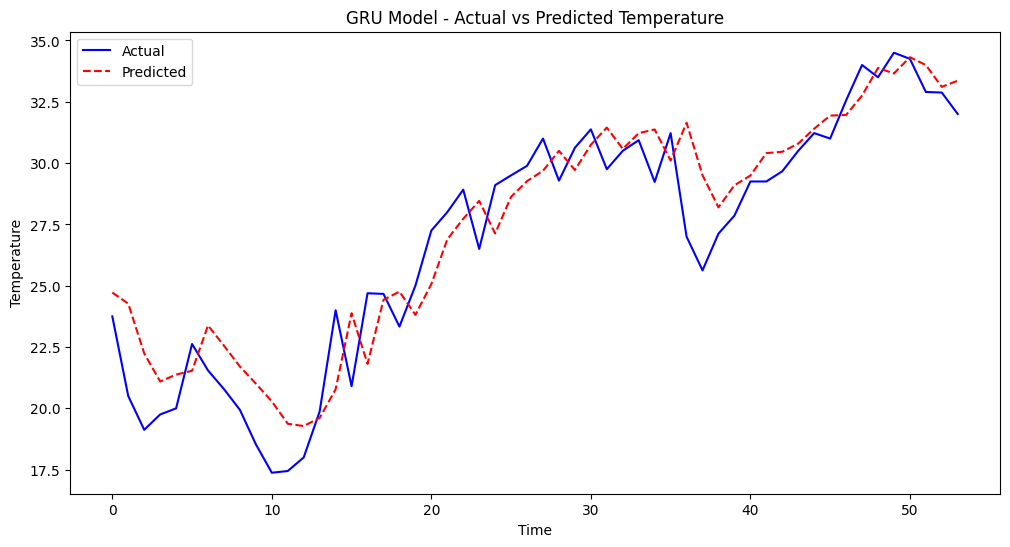

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(actuals_original, label="Actual", color='blue')
plt.plot(predictions_original, label="Predicted", color='red', linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("GRU Model - Actual vs Predicted Temperature")
plt.show()